# **Adding The important libraries**

In [ ]:
import os
import csv
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import pandas as pd

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D, Conv2DTranspose, MaxPooling2D, concatenate, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from tensorflow.keras import layers
from keras.utils import np_utils
from keras.datasets import mnist
import numpy as np
from sklearn.model_selection import train_test_split
import cv2
import math
from numpy import *
from skimage.metrics import structural_similarity as ssim
# demonstrate data standardization with sklearn
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
import keras
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import PIL

In [ ]:
from google.colab import drive
drive.mount( '/content/drive' )

Mounted at /content/drive


# **Adding userful function**

In [ ]:
def standard_norm(x_train, x_valid, axis=0):
    m = np.mean(x_train,axis = axis, keepdims=True)
    st = np.std(x_train,axis = axis, keepdims=True)
    x_train -= m;    x_train /= st
    x_valid -= m;    x_valid /= st
    return x_train, x_valid, m, st

In [ ]:
def re_standart_norm(Dataset_1, Dataset_2, st, m):
  Dataset_1 *= st
  Dataset_1 +=m
  Dataset_2 *= st
  Dataset_2 +=m

In [ ]:
def vmin_vmax(Matrix_A,Matrix_B):
  max_A = np.max(Matrix_A)
  min_A = np.min(Matrix_A)

  max_B = np.max(Matrix_B)
  min_B = np.min(Matrix_B)

  if(max_A>max_B):
    vmax=max_A
  else:
    vmax=max_B

  if(min_A<min_B):
    vmin=min_A
  else:
    vmin=min_B

  return vmax,vmin

In [ ]:
def psnr(image1, image2):
    """Tính giá trị PSNR giữa hai ảnh."""
    max_value = np.max(image2)
    mse = np.mean((image1 - image2) ** 2)
    psnr = 10 * np.log10((max_value ** 2) / mse)
    return psnr

In [ ]:
def SSIM1(list_img_original,list_img_predicted):
  result=[]
  for i in range(len(list_img_original)):
    result.append(ssim(list_img_original[i].reshape(80,56),list_img_predicted[i].reshape(80,56)))
  return result

In [ ]:
def Error_Image(real_image,predicted_image):
  list_RMSE=[]

  for i in range(len(real_image)):
    sum_error=0
    for k in range(real_image.shape[1]):
      for h in range(real_image.shape[2]):
        sum_error = sum_error + (real_image[i][k][h] - predicted_image[i][k][h])**2

    RMSE = (sum_error/(real_image.shape[1]*real_image.shape[2]))**(1/2)

    list_RMSE.append(RMSE)

  return list_RMSE

In [ ]:
def noisy(image):
  row,col= image.shape[0],image.shape[1]
  mean = 0
  var = 0.004
  sigma = var**0.5
  gauss = np.random.normal(mean,sigma,(row,col))
  gauss = gauss.reshape(row,col)
  noisy = image + gauss
  return noisy

In [ ]:
def Noise_Image(data):

  list_image_noise = []

  for i in range(len(data)):
    noise_image=noisy(data[i])
    list_image_noise.append(noise_image)

  return np.array(list_image_noise)

In [ ]:
def rot_image(list_images):
  images=[]
  for i in range(len(list_images)):
    cache = np.rot90(list_images[i], k=1)
    flipped_arr = np.flip(cache, axis=0)
    images.append(flipped_arr)
  images=np.array(images)
  return images

In [ ]:
def Down_sampling_single_image(images,down_size):
    height = int(images.shape[0]/down_size)
    width = int(images.shape[1]/down_size)
    images = cv2.resize(images, (width, height), interpolation = cv2.INTER_CUBIC)
    return images

In [ ]:
def Down_sampling_list_image(list_image,down_size):

    list_image_downsampling=[]

    for i in range(len(list_image)):
      img = list_image[i]
      img = Down_sampling_single_image(img,down_size)
      list_image_downsampling.append(img)

    return np.array(list_image_downsampling)

In [ ]:
def resblock(x, kernelsize, filters):
    fx = Conv2D(filters, kernelsize, padding='same')(x)
    fx = BatchNormalization()(fx)
    fx = layers.ReLU()(fx)
    fx = Conv2D(filters, kernelsize, padding='same')(fx)
    fx = BatchNormalization()(fx)
    outputs = layers.Add()([fx,x])
    return outputs

In [ ]:
def vmin_vmax(Matrix_A,Matrix_B):
  max_A = np.max(Matrix_A)
  min_A = np.min(Matrix_A)

  max_B = np.max(Matrix_B)
  min_B = np.min(Matrix_B)

  if(max_A>max_B):
    vmax=max_A
  else:
    vmax=max_B

  if(min_A<min_B):
    vmin=min_A
  else:
    vmin=min_B

  return vmax,vmin

In [ ]:
def SSIM(list_img_original,list_img_predicted):
  result=[]
  for i in range(len(list_img_original)):
    result.append(ssim(list_img_original[i],list_img_predicted[i]))
  return result

In [ ]:
def Plot_2D(list_data,file_name,V_min,V_max):
    fig=plt.figure(figsize=(16,6))

    vmin_flag=V_min
    vmax_flag=V_max

    list_data=np.array(list_data)

    plt.subplot(2,5,1)
    x_plot=list_data[0]
    plt.imshow(x_plot,vmin=vmin_flag,vmax=vmax_flag,origin="lower",interpolation="bilinear",cmap=plt.cm.jet,aspect="auto")
    plt.tight_layout(pad=0, h_pad=None, w_pad=None, rect=(0, 0, 1, 1))
    plt.axis('off')
    #----------------------------------------------------------------------------------------------------------------------------------

    plt.subplot(2,5,2)
    x_plot=list_data[1]
    plt.imshow(x_plot,vmin=vmin_flag,vmax=vmax_flag,origin="lower",interpolation="bilinear",cmap=plt.cm.jet,aspect="auto")
    plt.tight_layout(pad=0, h_pad=None, w_pad=None, rect=(0, 0, 1, 1))
    plt.axis('off')
    #----------------------------------------------------------------------------------------------------------------------------------

    plt.subplot(2,5,3)
    x_plot=list_data[2]
    plt.imshow(x_plot,vmin=vmin_flag,vmax=vmax_flag,origin="lower",interpolation="bilinear",cmap=plt.cm.jet,aspect="auto")
    plt.tight_layout(pad=0, h_pad=None, w_pad=None, rect=(0, 0, 1, 1))
    plt.axis('off')
    #-----------------------------------------------------------------------------------------------------------------------------------

    plt.subplot(2,5,4)
    x_plot=list_data[3]
    plt.imshow(x_plot,vmin=vmin_flag,vmax=vmax_flag,origin="lower",interpolation="bilinear",cmap=plt.cm.jet,aspect="auto")
    plt.tight_layout(pad=0, h_pad=None, w_pad=None, rect=(0, 0, 1, 1))
    plt.axis('off')
    #------------------------------------------------------------------------------------------------------------------------------------

    plt.subplot(2,5,5)
    x_plot=list_data[4]
    plt.imshow(x_plot,vmin=vmin_flag,vmax=vmax_flag,origin="lower",interpolation="bilinear",cmap=plt.cm.jet,aspect="auto")
    plt.tight_layout(pad=0, h_pad=None, w_pad=None, rect=(0, 0, 1, 1))
    plt.axis('off')
    #-------------------------------------------------------------------------------------------------------------------------------------

    plt.subplot(2,5,6)
    x_plot=list_data[5]
    plt.imshow(x_plot,vmin=vmin_flag,vmax=vmax_flag,origin="lower",interpolation="bilinear",cmap=plt.cm.jet,aspect="auto")
    plt.tight_layout(pad=0, h_pad=None, w_pad=None, rect=(0, 0, 1, 1))
    plt.axis('off')
    #---------------------------------------------------------------------------------------------------------------------------------------

    plt.subplot(2,5,7)
    x_plot=list_data[6]
    plt.imshow(x_plot,vmin=vmin_flag,vmax=vmax_flag,origin="lower",interpolation="bilinear",cmap=plt.cm.jet,aspect="auto")
    plt.tight_layout(pad=0, h_pad=None, w_pad=None, rect=(0, 0, 1, 1))
    plt.axis('off')
    #----------------------------------------------------------------------------------------------------------------------------------------

    plt.subplot(2,5,8)
    x_plot=list_data[7]
    plt.imshow(x_plot,vmin=vmin_flag,vmax=vmax_flag,origin="lower",interpolation="bilinear",cmap=plt.cm.jet,aspect="auto")
    plt.tight_layout(pad=0, h_pad=None, w_pad=None, rect=(0, 0, 1, 1))
    plt.axis('off')
    #-----------------------------------------------------------------------------------------------------------------------------------------

    plt.subplot(2,5,9)
    x_plot=list_data[8]
    plt.imshow(x_plot,vmin=vmin_flag,vmax=vmax_flag,origin="lower",interpolation="bilinear",cmap=plt.cm.jet,aspect="auto")
    plt.tight_layout(pad=0, h_pad=None, w_pad=None, rect=(0, 0, 1, 1))
    plt.axis('off')
    #------------------------------------------------------------------------------------------------------------------------------------------

    plt.subplot(2,5,10)
    x_plot=list_data[9]
    plt.imshow(x_plot,vmin=vmin_flag,vmax=vmax_flag,origin="lower",interpolation="bilinear",cmap=plt.cm.jet,aspect="auto")
    plt.tight_layout(pad=0, h_pad=None, w_pad=None, rect=(0, 0, 1, 1))
    plt.axis('off')

    fig.savefig(file_name + '.png', format='png')

In [ ]:
def Plot_2D_None(list_data,file_name,V_min,V_max):
    fig=plt.figure(figsize=(16,6))

    vmin_flag=V_min
    vmax_flag=V_max

    list_data=np.array(list_data)

    plt.subplot(2,5,1)
    x_plot=list_data[0]
    plt.imshow(x_plot,vmin=vmin_flag,vmax=vmax_flag,origin="lower",interpolation=None,cmap=plt.cm.jet,aspect="auto")
    plt.tight_layout(pad=0, h_pad=None, w_pad=None, rect=(0, 0, 1, 1))
    plt.axis('off')
    #----------------------------------------------------------------------------------------------------------------------------------

    plt.subplot(2,5,2)
    x_plot=list_data[1]
    plt.imshow(x_plot,vmin=vmin_flag,vmax=vmax_flag,origin="lower",interpolation=None,cmap=plt.cm.jet,aspect="auto")
    plt.tight_layout(pad=0, h_pad=None, w_pad=None, rect=(0, 0, 1, 1))
    plt.axis('off')
    #----------------------------------------------------------------------------------------------------------------------------------

    plt.subplot(2,5,3)
    x_plot=list_data[2]
    plt.imshow(x_plot,vmin=vmin_flag,vmax=vmax_flag,origin="lower",interpolation=None,cmap=plt.cm.jet,aspect="auto")
    plt.tight_layout(pad=0, h_pad=None, w_pad=None, rect=(0, 0, 1, 1))
    plt.axis('off')
    #-----------------------------------------------------------------------------------------------------------------------------------

    plt.subplot(2,5,4)
    x_plot=list_data[3]
    plt.imshow(x_plot,vmin=vmin_flag,vmax=vmax_flag,origin="lower",interpolation=None,cmap=plt.cm.jet,aspect="auto")
    plt.tight_layout(pad=0, h_pad=None, w_pad=None, rect=(0, 0, 1, 1))
    plt.axis('off')
    #------------------------------------------------------------------------------------------------------------------------------------

    plt.subplot(2,5,5)
    x_plot=list_data[4]
    plt.imshow(x_plot,vmin=vmin_flag,vmax=vmax_flag,origin="lower",interpolation=None,cmap=plt.cm.jet,aspect="auto")
    plt.tight_layout(pad=0, h_pad=None, w_pad=None, rect=(0, 0, 1, 1))
    plt.axis('off')
    #-------------------------------------------------------------------------------------------------------------------------------------

    plt.subplot(2,5,6)
    x_plot=list_data[5]
    plt.imshow(x_plot,vmin=vmin_flag,vmax=vmax_flag,origin="lower",interpolation=None,cmap=plt.cm.jet,aspect="auto")
    plt.tight_layout(pad=0, h_pad=None, w_pad=None, rect=(0, 0, 1, 1))
    plt.axis('off')
    #---------------------------------------------------------------------------------------------------------------------------------------

    plt.subplot(2,5,7)
    x_plot=list_data[6]
    plt.imshow(x_plot,vmin=vmin_flag,vmax=vmax_flag,origin="lower",interpolation=None,cmap=plt.cm.jet,aspect="auto")
    plt.tight_layout(pad=0, h_pad=None, w_pad=None, rect=(0, 0, 1, 1))
    plt.axis('off')
    #----------------------------------------------------------------------------------------------------------------------------------------

    plt.subplot(2,5,8)
    x_plot=list_data[7]
    plt.imshow(x_plot,vmin=vmin_flag,vmax=vmax_flag,origin="lower",interpolation=None,cmap=plt.cm.jet,aspect="auto")
    plt.tight_layout(pad=0, h_pad=None, w_pad=None, rect=(0, 0, 1, 1))
    plt.axis('off')
    #-----------------------------------------------------------------------------------------------------------------------------------------

    plt.subplot(2,5,9)
    x_plot=list_data[8]
    plt.imshow(x_plot,vmin=vmin_flag,vmax=vmax_flag,origin="lower",interpolation=None,cmap=plt.cm.jet,aspect="auto")
    plt.tight_layout(pad=0, h_pad=None, w_pad=None, rect=(0, 0, 1, 1))
    plt.axis('off')
    #------------------------------------------------------------------------------------------------------------------------------------------

    plt.subplot(2,5,10)
    x_plot=list_data[9]
    plt.imshow(x_plot,vmin=vmin_flag,vmax=vmax_flag,origin="lower",interpolation=None,cmap=plt.cm.jet,aspect="auto")
    plt.tight_layout(pad=0, h_pad=None, w_pad=None, rect=(0, 0, 1, 1))
    plt.axis('off')

    fig.savefig(file_name + '.png', format='png')

In [ ]:
# plot images from the training dataset
def _plot(X):
	for i in range(25):
		# define subplot
		plt.subplot(5, 5, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(X[i], cmap='gray_r')
	plt.show()

In [ ]:
#This functions helps me to zoom-in area in image
def plot_results(img, prefix, title):
    """Plot the result with zoom-in area."""
    img_array = img_to_array(img)
    img_array = img_array.astype("float32") / 255.0

    # Create a new figure with a default 111 subplot.
    fig, ax = plt.subplots()
    im = ax.imshow(img_array[::-1], origin="lower")

    plt.title(title)
    # zoom-factor: 2.0, location: upper-left
    axins = zoomed_inset_axes(ax, 2, loc=2)
    axins.imshow(img_array[::-1], origin="lower")

    if(img.shape[0]>=300):
      # Specify the limits.
      x1, x2, y1, y2 = 150, 200, 250, 300
      # Apply the x-limits.
      axins.set_xlim(x1, x2)
      # Apply the y-limits.
      axins.set_ylim(y1, y2)
    else:
      # Specify the limits.
      x1, x2, y1, y2 = 30, 30, 30, 30
      # Apply the x-limits.
      axins.set_xlim(x1, x2)
      # Apply the y-limits.
      axins.set_ylim(y1, y2)

    plt.yticks(visible=False)
    plt.xticks(visible=False)

    # Make the line.
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="lime")
    plt.savefig(str(prefix) + "-" + title + ".png")
    plt.show()

# ***Model DNN***

In [ ]:
def FSRCNN(img_height,img_width,upsize):
    img_width = int(img_width/upsize)
    img_height = int(img_height/upsize)

    # FSRCNN parameters (from paper)
    d = 48
    s = 16
    m = 3
    upscale = upsize

    # define sequential model
    fsrcnn = Sequential()


    # feature extraction
    fsrcnn.add(
            tf.keras.layers.Conv2D(
                input_shape=(img_width, img_height, 1),
                filters=d,
                kernel_size=5,
                padding="same",
                kernel_initializer=tf.keras.initializers.he_normal()
            )
        )
    fsrcnn.add(tf.keras.layers.PReLU(shared_axes=[1, 2]))

    # shrinking
    fsrcnn.add(
            tf.keras.layers.Conv2D(
                filters=s,
                kernel_size=1,
                padding="same",
                kernel_initializer=tf.keras.initializers.he_normal(),
            )
        )
    fsrcnn.add(tf.keras.layers.PReLU(shared_axes=[1, 2]))


    # nonlinear mapping (m layers)
    for i in range(m):
      fsrcnn.add(
            tf.keras.layers.Conv2D(
                filters=s,
                kernel_size=3,
                padding="same",
                kernel_initializer=tf.keras.initializers.he_normal(),
            )
        )
      fsrcnn.add(tf.keras.layers.PReLU(shared_axes=[1, 2]))


    # expand
    fsrcnn.add(
            tf.keras.layers.Conv2D(
                filters=d,
                kernel_size=1,
                padding="same",
                kernel_initializer=tf.keras.initializers.he_normal(),
            )
        )
    fsrcnn.add(tf.keras.layers.PReLU(shared_axes=[1, 2]))

    # deconvolution
    fsrcnn.add(
            tf.keras.layers.Conv2DTranspose(
                filters=1,
                kernel_size=9,
                strides=(upscale, upscale),
                padding="same",
                kernel_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.001),
            )
        )

    return fsrcnn

In [ ]:
def Generator_network(img_width,img_height,upsize):

    img_width = int(img_width/upsize)
    img_height = int(img_height/upsize)

    inputs = tf.keras.layers.Input((img_height,img_width,1))

    c1 = Conv2D(48,(9,9),activation='PReLU',kernel_initializer='he_normal', padding='same')(inputs)

    #residual block
    residual_1 = resblock(c1,3,48)

    residual_2 = resblock(residual_1,3,48)

    residual_3 = resblock(residual_2,3,48)

    residual_4 = resblock(residual_3,3,48)

    c2 = Conv2D(48,(3,3),activation='PReLU',kernel_initializer='he_normal', padding='same')(residual_4)
    c2 = BatchNormalization()(c2)

    c2 = Conv2D(48,(3,3),activation='PReLU',kernel_initializer='he_normal', padding='same')(c2)
    c2 = BatchNormalization()(c2)

    c2 = Conv2D(48,(3,3),activation='PReLU',kernel_initializer='he_normal', padding='same')(c2)
    c2 = BatchNormalization()(c2)

    c2 = Conv2D(48,(3,3),activation='PReLU',kernel_initializer='he_normal', padding='same')(c2)
    c2 = BatchNormalization()(c2)

    c3 = layers.Add()([c1,c2])

    outputs = Conv2D(1,(9,9),activation='PReLU',kernel_initializer='he_normal', padding='same')(c3)

    model = tf.keras.Model(inputs=[inputs],outputs=[outputs])

    return model

In [ ]:
def combined_model(model1, model2):
    outputs = model2(model1.output)
    return Model(inputs=model1.input, outputs=outputs)

# ***Load Data***

In [ ]:
Train_high = pd.read_csv("/content/drive/MyDrive/Rivet Super Resolution/Data/Train_high.hdf5")

Train_high = np.array(Train_high.iloc[:,1:].values)

Train_high = Train_high.reshape(4723,80,56)

Test_high = pd.read_csv("/content/drive/MyDrive/Rivet Super Resolution/Data/Test_high.hdf5")

Test_high = np.array(Test_high.iloc[:,1:].values)

Test_high = Test_high.reshape(1181,80,56)

print(Train_high.shape)
print(Test_high.shape)

(4723, 80, 56)
(1181, 80, 56)


In [ ]:
Train_high_noise = Noise_Image(Train_high)
Test_high_noise = Noise_Image(Test_high)

In [ ]:
Train_low_noise = Down_sampling_list_image(Train_high_noise,8)
Test_low_noise = Down_sampling_list_image(Test_high_noise,8)

In [ ]:
Train_low = Down_sampling_list_image(Train_high,8)
Test_low = Down_sampling_list_image(Test_high,8)

# ***Train Combine Model***

In [ ]:
model1 = Generator_network(Train_high.shape[2],Train_high.shape[1],8)
model2 = FSRCNN(Train_high.shape[2],Train_high.shape[1],8)

combineMD = combined_model(model1,model2)

adam = Adam(lr=0.00003)
combineMD.compile(optimizer='adam',loss='mean_squared_error')

#Creating Callbacks
filepath="checkpoint_combine_model_noise_2_mean_var_0.004.hdf5"
callback = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
history=combineMD.fit([Train_low_noise],Train_high, epochs=200, batch_size=16,validation_data=([Test_low_noise],Test_high),callbacks=[callback])

Epoch 1/200
296/296 [==============================] - ETA: 0s - loss: 0.0033
Epoch 1: val_loss improved from inf to 0.00236, saving model to checkpoint_combine_model_noise_2_mean_var_0.004.hdf5
296/296 [==============================] - 21s 24ms/step - loss: 0.0033 - val_loss: 0.0024
Epoch 2/200
296/296 [==============================] - ETA: 0s - loss: 0.0014
Epoch 2: val_loss improved from 0.00236 to 0.00150, saving model to checkpoint_combine_model_noise_2_mean_var_0.004.hdf5
296/296 [==============================] - 5s 17ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 3/200
295/296 [============================>.] - ETA: 0s - loss: 0.0012
Epoch 3: val_loss improved from 0.00150 to 0.00101, saving model to checkpoint_combine_model_noise_2_mean_var_0.004.hdf5
296/296 [==============================] - 6s 20ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 4/200
294/296 [============================>.] - ETA: 0s - loss: 0.0010
Epoch 4: val_loss improved from 0.00101 to 0.00091, saving

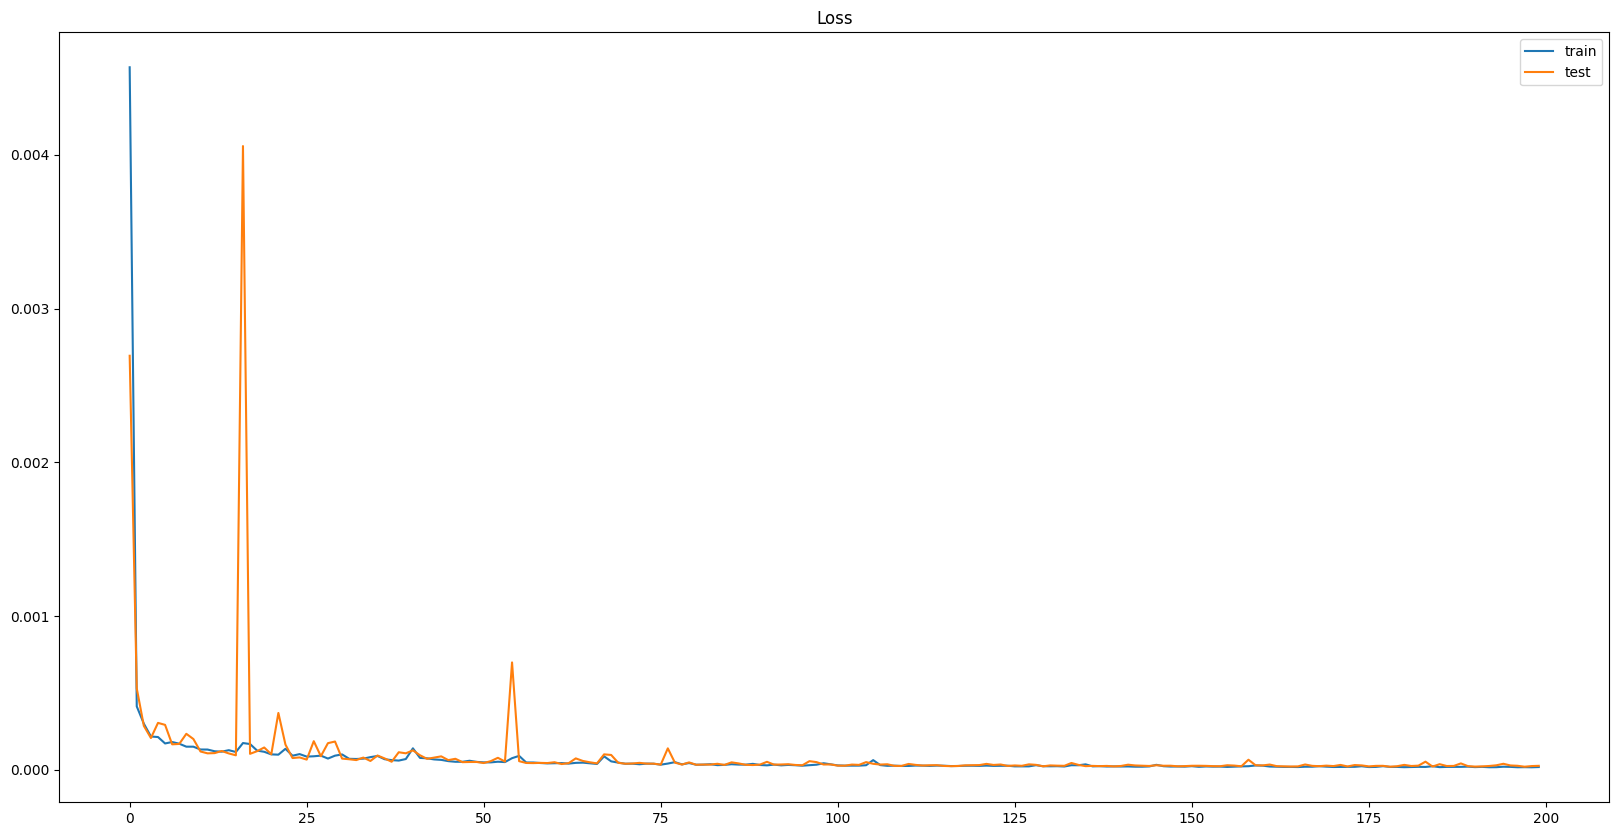

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(111)
plt.title('Loss')
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.legend()

# ***Train FSRCNN***

In [ ]:
# model1 = Generator_network(Train_high.shape[2],Train_high.shape[1],4)
model2 = FSRCNN(Train_high.shape[2],Train_high.shape[1],8)

# combineMD = combined_model(model1,model2)

adam = Adam(lr=0.00003)
model2.compile(optimizer='adam',loss='mean_squared_error')

#Creating Callbacks
filepath="checkpoint_FSRCNN_noise_mean_0.004_var_0.001.hdf5"
callback = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
history=model2.fit([Train_low_noise],Train_high, epochs=200, batch_size=16,validation_data=([Test_low_noise],Test_high),callbacks=[callback])

Epoch 1/200
296/296 [==============================] - ETA: 0s - loss: 0.0040
Epoch 1: val_loss improved from inf to 0.00164, saving model to checkpoint_FSRCNN_noise_mean_0.004_var_0.001.hdf5
296/296 [==============================] - 8s 9ms/step - loss: 0.0040 - val_loss: 0.0016
Epoch 2/200
288/296 [============================>.] - ETA: 0s - loss: 0.0014
Epoch 2: val_loss improved from 0.00164 to 0.00122, saving model to checkpoint_FSRCNN_noise_mean_0.004_var_0.001.hdf5
296/296 [==============================] - 2s 7ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 3/200
296/296 [==============================] - ETA: 0s - loss: 0.0012
Epoch 3: val_loss improved from 0.00122 to 0.00103, saving model to checkpoint_FSRCNN_noise_mean_0.004_var_0.001.hdf5
296/296 [==============================] - 2s 7ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 4/200
293/296 [============================>.] - ETA: 0s - loss: 9.7926e-04
Epoch 4: val_loss did not improve from 0.00103
296/296 [===========

# ***Predicted Images From Model***

In [ ]:
X_eval = combineMD.predict([Test_low_noise])

37/37 [==============================] - 1s 7ms/step


In [ ]:
X_eval.shape

(1181, 80, 56, 1)

In [ ]:
RMSE = Error_Image(Test_high, X_eval)

In [ ]:
np.average(RMSE)

0.017987283

In [ ]:
Value_SSIM = SSIM1(Test_high, X_eval)

In [ ]:
np.average(Value_SSIM)

0.9241438177649831

# ***Caculate SSIM***

In [ ]:
X_eval = X_eval.reshape(1181,80,56)

In [ ]:
list_tam=[]
for i in range(len(X_eval)):
  tam_1,tam_2=vmin_vmax(X_eval[i],Test_high[i])
  tam = psnr(X_eval[i],Test_high[i])
  list_tam.append(tam)

In [ ]:
np.average(list_tam)

48.08189197494698

# **Plot Image Down Sample 4 Times**

In [ ]:
Images_Predicted = X_eval[0:10]

In [ ]:
Images_Predicted = rot_image(Images_Predicted)

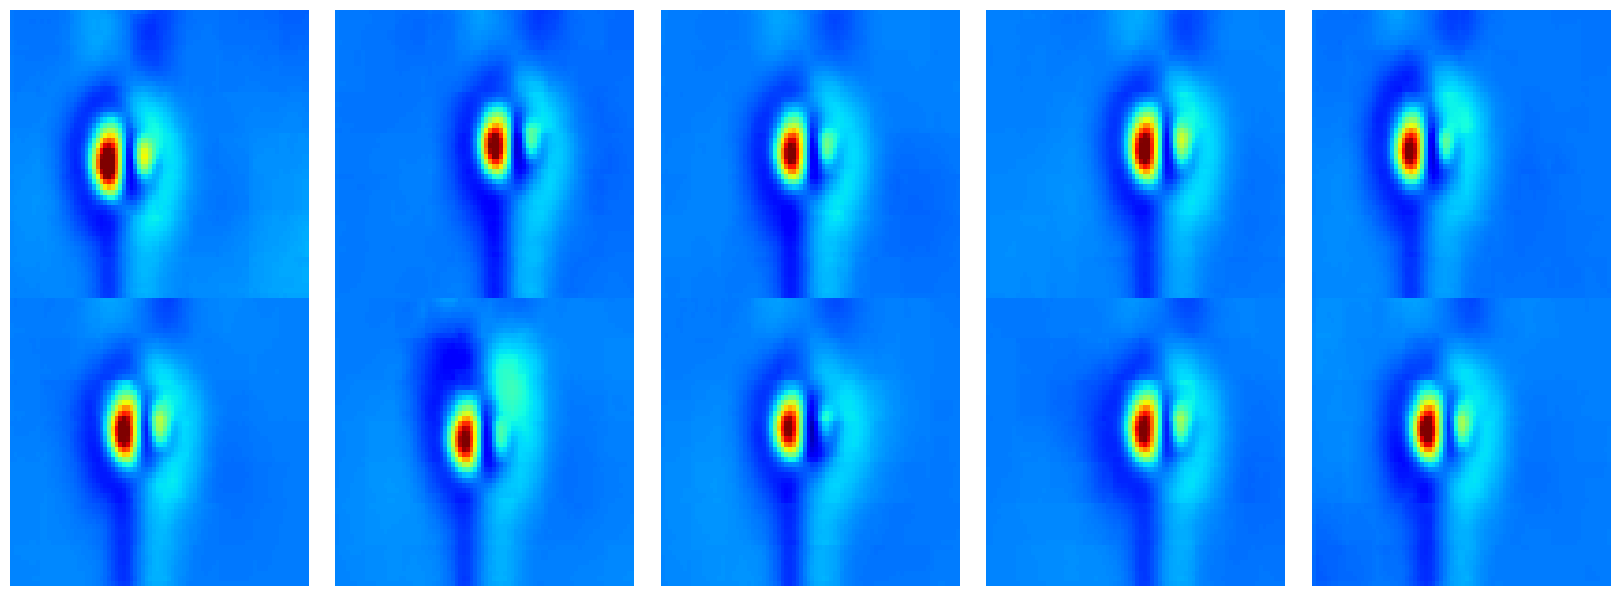

In [ ]:
Plot_2D_None(Images_Predicted,"predicted_image_None_2_noise",-0.4,1.2)

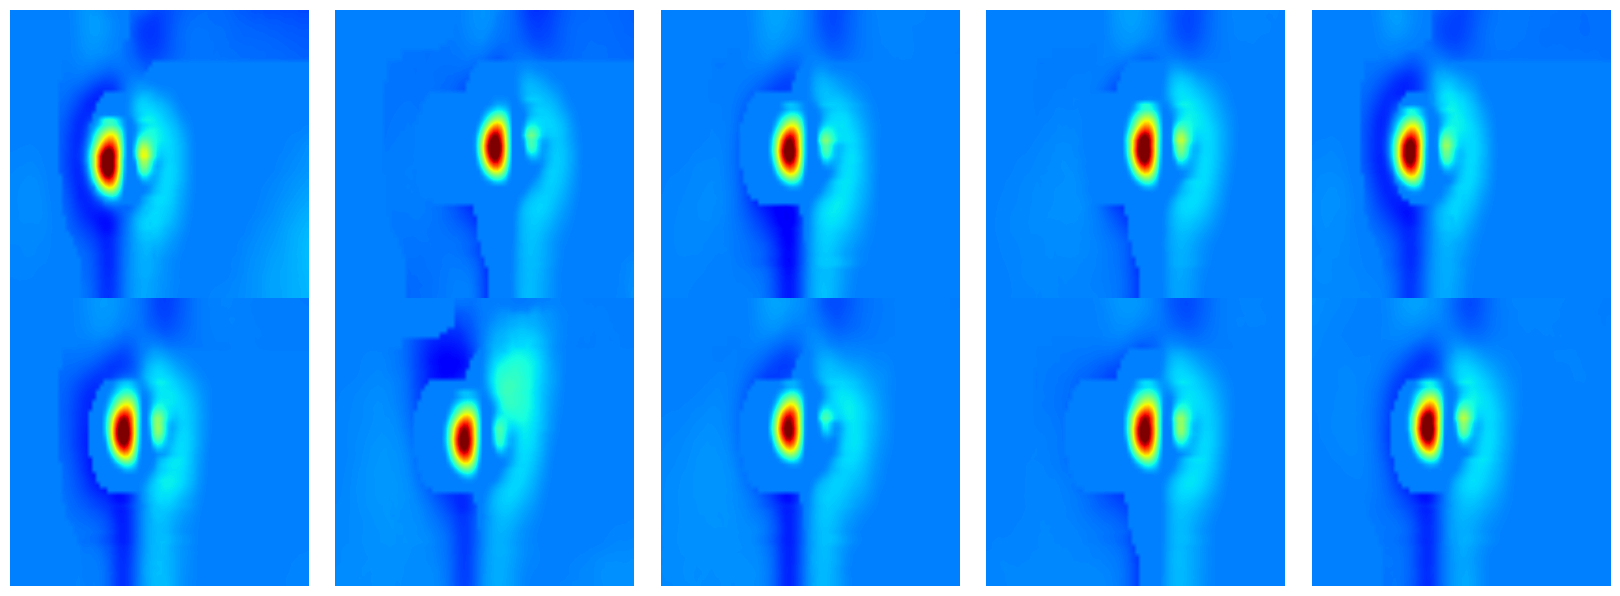

In [ ]:
Plot_2D(Images_Predicted,"predicted_image_4_noise",-0.4,+1.2)

In [ ]:
Images_Test = Test_high[:10]
Images_Test = rot_image(Images_Test)

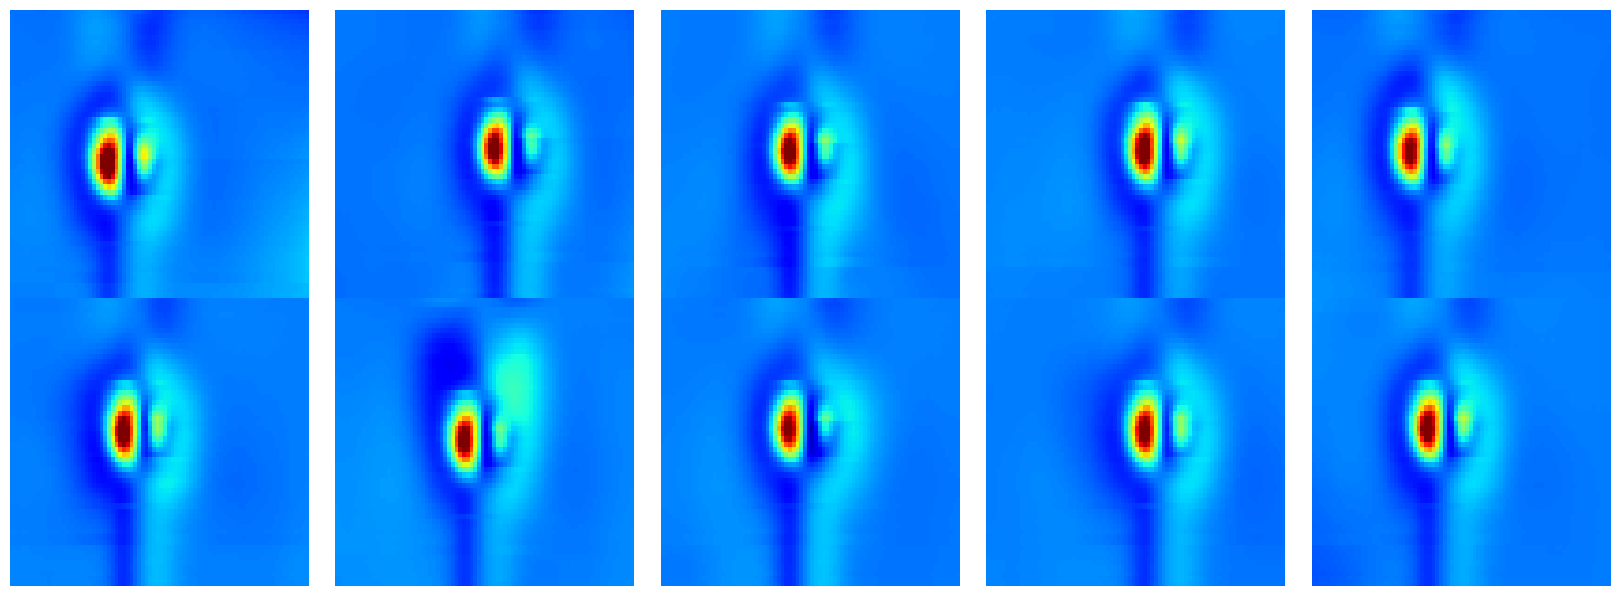

In [ ]:
Plot_2D_None(Images_Test,"Test_image_None_4_noise",-0.4,1.2)

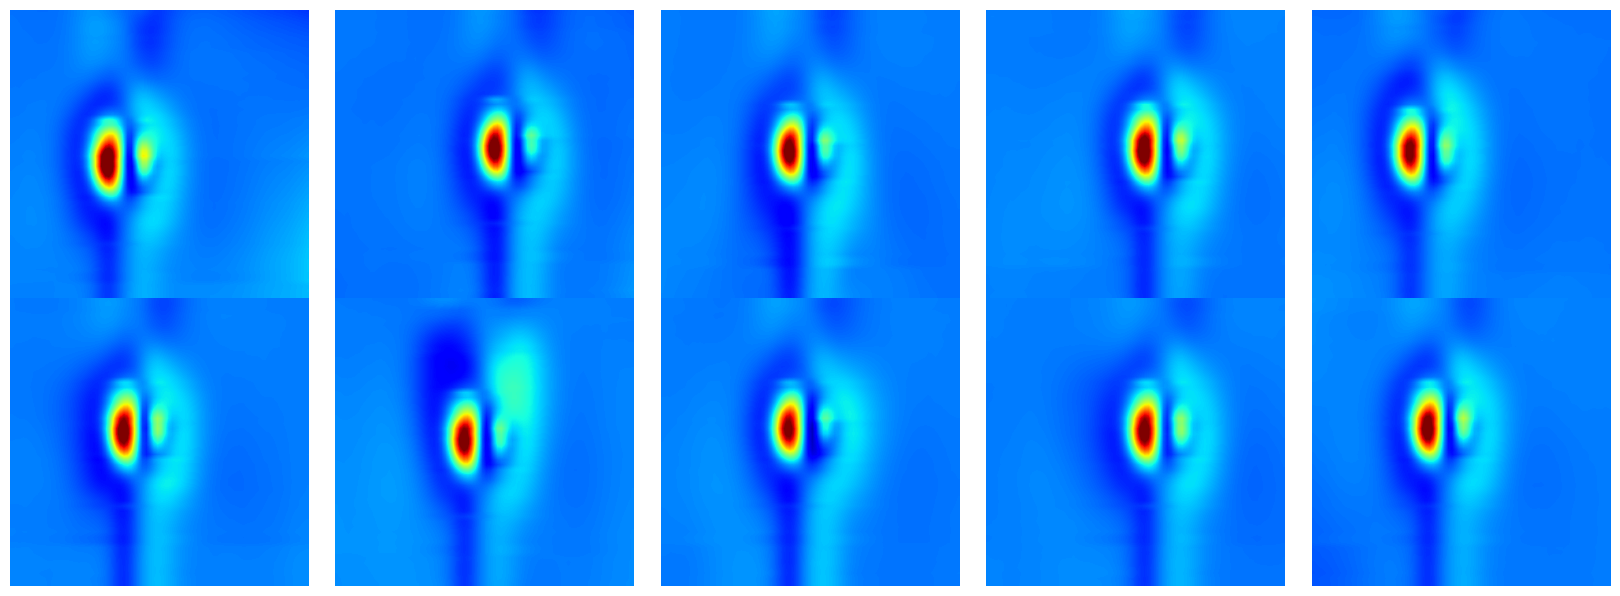

In [ ]:
Plot_2D(Images_Test,"Test_image_4_noise",-0.4,1.2)

In [ ]:
Low_Images = Test_low_noise[:10]
Low_Images = rot_image(Low_Images)

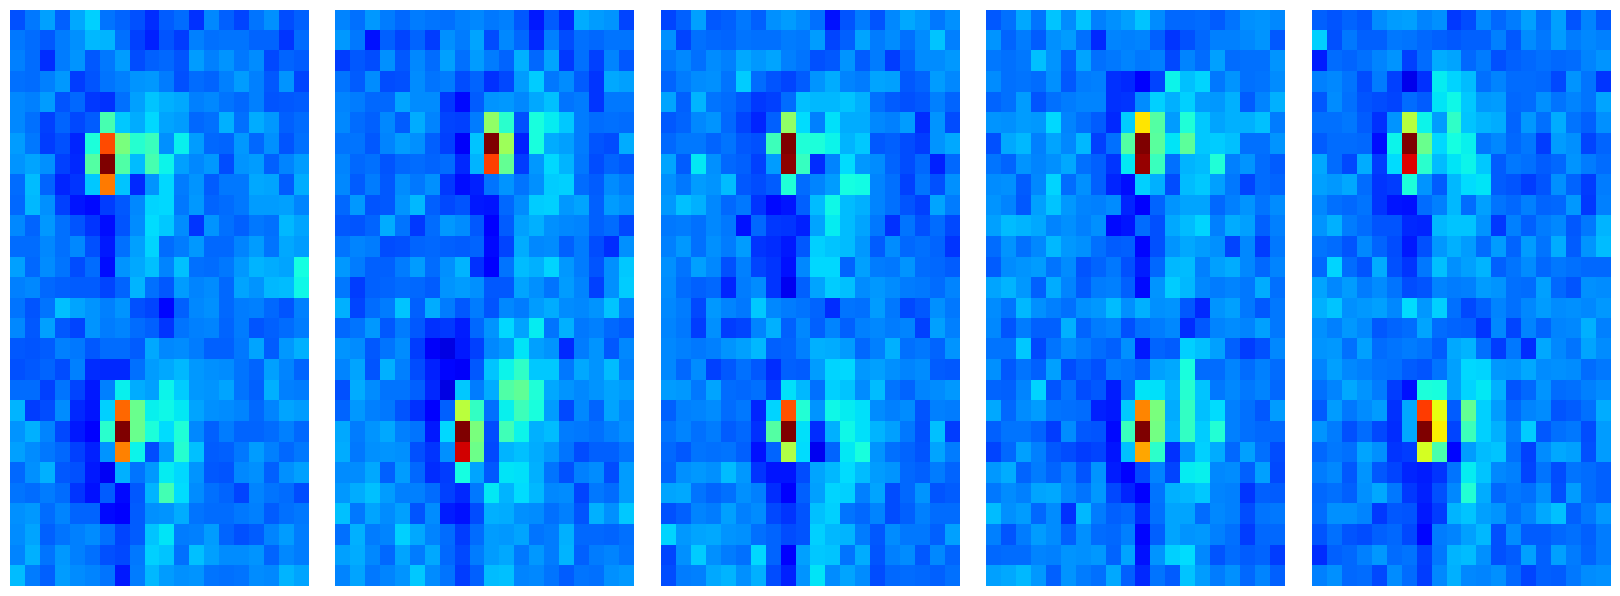

In [ ]:
Plot_2D_None(Low_Images,"Low_image_None_2_noise",-0.4,1.2)

In [ ]:
Low_Images = X_eval_tam[:10]
Low_Images = rot_image(Low_Images)

In [ ]:
Test_high.shape

(1181, 80, 56)

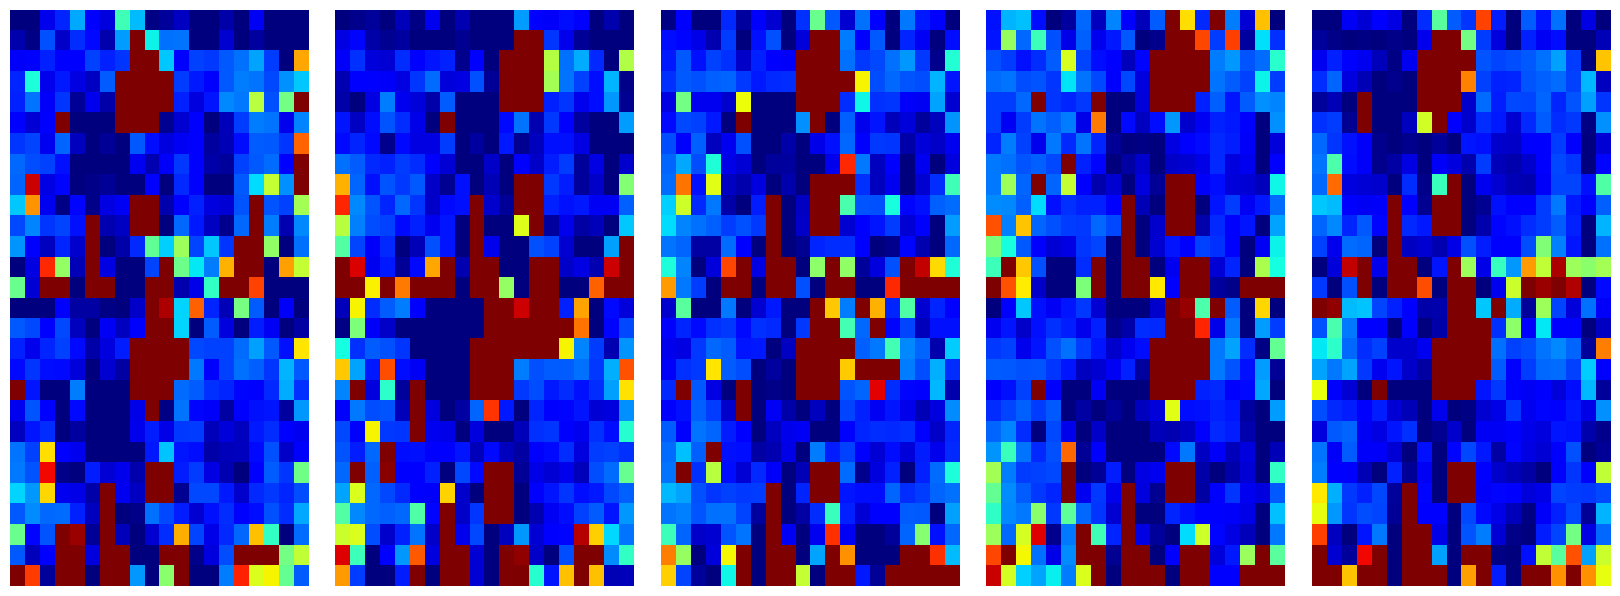

In [ ]:
Plot_2D_None(Low_Images,"Low_image_None_2_noise",-0.4,1.2)

In [ ]:
Test_high_Images = Test_high_noise[:10]
Test_high_Images = rot_image(Test_high_Images)

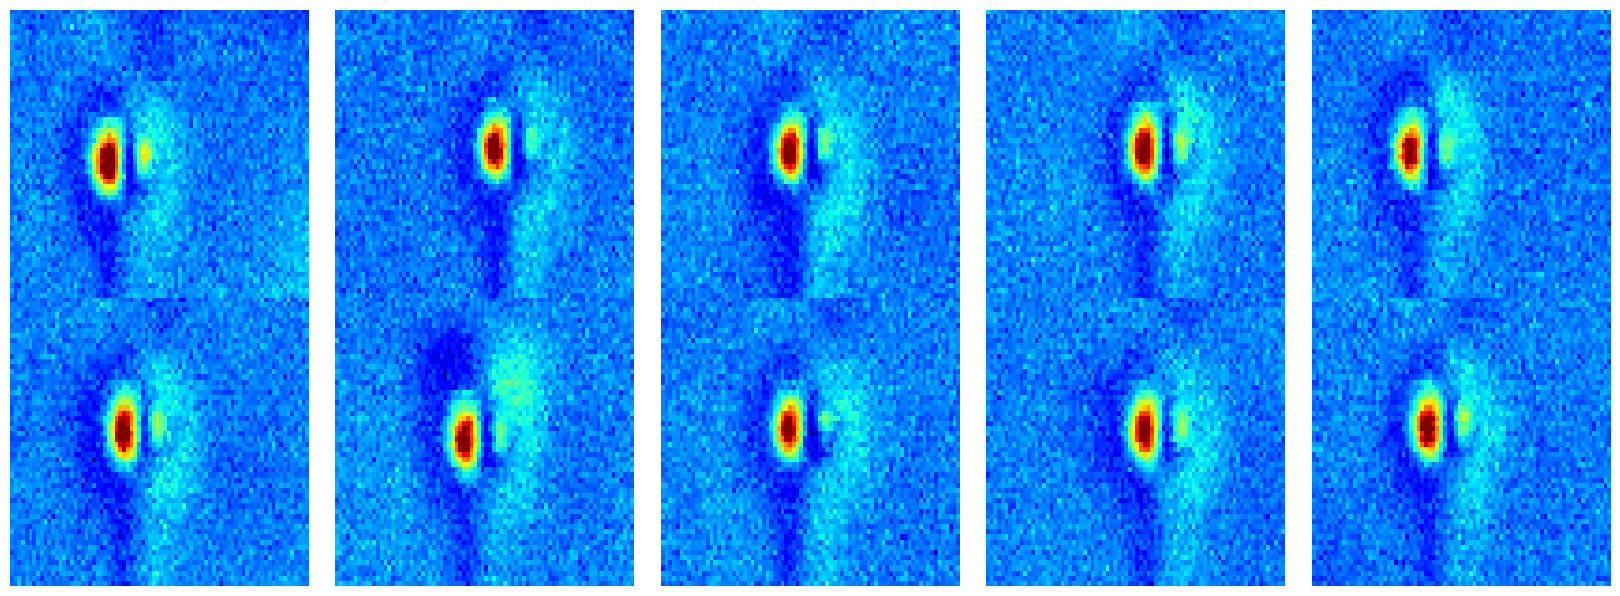

In [ ]:
Plot_2D_None(Test_high_Images,"High_image_test_None_8_noise",-0.4,1.2)